Read satellite data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
def read_satellite_data(veg_type, satellite):
    # Load vegetation class table
    veg_class = pd.read_csv('../data/veg_class_data/tables/veg_class.csv')
    df_satellite = pd.read_csv(f'../data/satellite_data/tables/phenology_climate/{satellite}.csv')
    df = pd.merge(df_satellite, veg_class, on=['latitude', 'longitude'], how='inner')
    # Filter for Forest classes
    if veg_type in (11, 12, 13, 14):
        df = df[df['veg_class'].isin([veg_type])]
    else:
        df = df[df['veg_class'].isin([11, 12, 13, 14])]
    
    # Separate climate/phenology columns by type
    eos_cols = [col for col in df.columns if 'eos' in col]
    t_cols = [col for col in df.columns if 'annual_t' in col]
    p_cols = [col for col in df.columns if 'annual_p' in col]
    sos_cols = [col for col in df.columns if 'sos' in col]

    if satellite == "avhrr":
        years = [str(y) for y in range(1982, 2017)]
    elif satellite == "modis":
        years = [str(y) for y in range(2001, 2024)]
        # Build boolean masks
        mask_sos = (df[sos_cols] < 0).any(axis=1)      # True if any sos < 0
        mask_eos = (df[eos_cols] > 365).any(axis=1)    # True if any eos > 365
        # Keep only rows that do NOT violate the conditions
        df = df[~(mask_sos | mask_eos)].copy()
    else:
        years = [str(y) for y in range(2013, 2023)]
        mask_sos = (df[sos_cols] < 0).any(axis=1)      # True if any sos < 0
        mask_eos = (df[eos_cols] > 365).any(axis=1)    # True if any eos > 365
        # Keep only rows that do NOT violate the conditions
        df = df[~(mask_sos | mask_eos)].copy()
        
    cols = years
    df = df[[col for col in eos_cols + t_cols + p_cols + sos_cols if any(y in col for y in cols)] + ['latitude', 'longitude', 'veg_class']].copy()
    t_cols_df = [col for col in df.columns if 'annual_t' in col]
    df[t_cols_df] = df[t_cols_df] - 273.5  # Convert temperature
    df.columns = df.columns.str.replace(r'\D*(\d{4})$', lambda m: f"{m.group(0)[0:-4]}{m.group(1)}", regex=True)
    df['annual_t'] = df[[col for col in df.columns if 'annual_t' in col]].mean(axis=1)
    df['annual_p'] = df[[col for col in df.columns if 'annual_p' in col]].mean(axis=1)
    df['eos'] = df[[col for col in df.columns if 'eos' in col]].mean(axis=1)
    df['sos'] = df[[col for col in df.columns if 'sos' in col]].mean(axis=1)
    return df

Plot heatmap

In [ ]:
## Plot heatmap with temp bin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.ticker import FormatStrFormatter

def filter_extremes(df, x_col, y_col, z_col):
    x_all = df[x_col].values
    y_all = df[y_col].values*1000
    z_all = df[z_col].values
    x_low, x_high = np.nanpercentile(x_all, [0, 100])
    y_low, y_high = np.nanpercentile(y_all, [0, 100])
    mask = (x_all >= x_low) & (x_all <= x_high) & (y_all >= y_low) & (y_all <= y_high)
    return x_all[mask], y_all[mask], z_all[mask]

def classify_data(x, y, satellite):
    # temp_class = np.where(x < np.nanmean(x), 'low temp', 'High temp')
    temp_class = np.where(x < 7.25, 'low temp', 'High temp')
    if satellite == 'avhrr':
        precip_class = np.where(y < 900, 'Low prcp', 'High prcp')
    elif satellite == 'modis':
        precip_class = np.where(y < 1000, 'Low prcp', 'High prcp')
    else:
        precip_class = np.where(y < 1100, 'Low prcp', 'High prcp')
    return temp_class, precip_class


def compute_binned_means(x, y, z, min_z_count):
    bin_width_x = 0.5     # 1 degree
    bin_width_y = 100   # 100 mm/year

    # Compute bin edges
    x_edges = np.arange(np.floor(x.min()), np.ceil(x.max()) + bin_width_x, bin_width_x)
    y_start = np.floor(y.min() / bin_width_y) * bin_width_y
    y_end = np.ceil(y.max() / bin_width_y) * bin_width_y
    y_edges = np.arange(y_start, y_end + bin_width_y, bin_width_y)

    # 2D histogram: sum and count
    z_sum, _, _ = np.histogram2d(x, y, bins=[x_edges, y_edges], weights=z)
    z_count, _, _ = np.histogram2d(x, y, bins=[x_edges, y_edges])

    # Compute mean where count >= threshold
    z_mean = np.full_like(z_sum, np.nan, dtype=np.float64)
    valid_mask = z_count >= min_z_count
    z_mean[valid_mask] = z_sum[valid_mask] / z_count[valid_mask]
    
    # Calculate bin centers for plotting
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
   
    print(f'Max count of grid: {np.nanmax(z_count)}')
    z_mean_masked = z_mean
    print(np.nanmin(z_mean_masked))

    return z_mean_masked, x_centers, y_centers

def plot_main_heatmap(x, y, z_mean, name1, name2, x_bins, y_bins, x_display_range, y_display_range, vlim, satellite):
    # ax = plt.subplot2grid((3, 4), (0, 1), rowspan=2, colspan=2)
    ax = plt.subplot2grid((6, 4), (0, 1), rowspan=3, colspan=2)

    cmap = LinearSegmentedColormap.from_list(
        "custom_cmap",
        ["#0b3c68", "#165188", "#2066a8", "#4d91c4", "#8ec1da", 
         "#fbebe1", "#f6d6c2", "#d47264", "#c14d48", "#ae282c"]
    )

    vmin, vmax = vlim
    norm = Normalize(vmin=vmin if vmin is not None else np.nanmin(z_mean),
                     vmax=vmax if vmax is not None else np.nanmax(z_mean))

    # Recover bin edges from centers
    x_step = x_bins[1] - x_bins[0]
    y_step = y_bins[1] - y_bins[0]
    x_edges = np.concatenate([[x_bins[0] - x_step / 2], x_bins + x_step / 2])
    y_edges = np.concatenate([[y_bins[0] - y_step / 2], y_bins + y_step / 2])

    ax.imshow(z_mean.T, origin='lower',
              extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
              cmap=cmap, norm=norm, aspect='auto')


    ax.set_xlim(*x_display_range)
    ax.set_ylim(*y_display_range)
    ax.set_yticks([400, 800, 1200, 1600])

    ax.set_ylabel("MAP (mm/year)", fontsize=14)
    ax.set_xticklabels([])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    if satellite == 'avhrr':
        ax.axhline(y=900, color='black', linestyle='--', linewidth=1.0)
        ax.vlines(x=7.25, ymin=ax.get_ylim()[0], ymax=900, 
          colors='black', linestyles='--', linewidth=1.0)
    elif satellite == 'modis':
        ax.axhline(y=1000, color='black', linestyle='--', linewidth=1.0)
        ax.vlines(x=6.75, ymin=ax.get_ylim()[0], ymax=1000, 
              colors='black', linestyles='--', linewidth=1.0)
    else: 
        ax.axhline(y=1100, color='black', linestyle='--', linewidth=1.0)
        ax.vlines(x=7.25, ymin=ax.get_ylim()[0], ymax=1100, 
              colors='black', linestyles='--', linewidth=1.0)

    # Wet regions (nudge left and down a bit)
    ax.text(x_display_range[1] - 0.5,   # move left by 0.5 units
            y_display_range[1] - 50,   # move down by 50 units
            "Wet regions",
            ha='right', va='top', fontsize=10, color='black')
    
    # Dry regions (nudge left and up a bit)
    ax.text(x_display_range[1] - 0.5,   # move left by 0.5 units
            y_display_range[0] + 50,   # move up by 50 units
            "Hot-dry regions",
            ha='right', va='bottom', fontsize=10, color='black')
    # Dry regions (nudge left and up a bit)
    ax.text(x_display_range[1] - 15,   # move left by 0.5 units
            y_display_range[0] + 18,   # move up by 50 units
            "Cold-dry regions",
            ha='right', va='bottom', fontsize=10, color='black')
    
    return ax, norm

def add_colorbar(fig, norm, z_col, vlim):
    ax_cbar = fig.add_axes([0.7, 0.55, 0.015, 0.35])
    cmap = LinearSegmentedColormap.from_list("custom_cmap",
            ["#0b3c68", "#165188", "#2066a8", "#4d91c4", "#8ec1da", 
            "#fbebe1", "#f6d6c2", "#d47264", "#c14d48", "#ae282c"])

    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax_cbar)
    if vlim == (250, 305):
        cbar.set_ticks([260, 280, 300])
    elif vlim == (235, 285):
        cbar.set_ticks([240, 260, 280])
    else:
        cbar.set_ticks([250, 270, 290])
        
    if z_col == "eos":
        cbar.ax.set_ylabel("EOS (DOY)", fontsize=14)
        cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
    cbar.ax.tick_params(labelsize=12)

    
def plot_heat_map(df, x_col, y_col, z_col, name1, name2, name3, title, vlim, min_z_count, satellite):
    x_display_range = (-7, 20)
    y_display_range = (300, 1750)
    x, y, z = filter_extremes(df, x_col, y_col, z_col)
    temp_class, precip_class = classify_data(x, y, satellite)
    z_mean, x_bins, y_bins = compute_binned_means(x, y, z, min_z_count)
    mid_x = (x_bins[:-1] + x_bins[1:]) / 2
    mid_y = (y_bins[:-1] + y_bins[1:]) / 2
    fig = plt.figure(figsize=(12, 6))
    ax_main, norm = plot_main_heatmap(x, y, z_mean, name1, name2, x_bins, y_bins, x_display_range, y_display_range, vlim, satellite)
    
    ax2 = plot_bottom_subplot(x, y, z_mean, x_bins, y_bins, precip_class, mid_x, x_display_range, z, vlim, satellite)
    add_colorbar(fig, norm, z_col, vlim)
    fig.subplots_adjust(left=0.08, right=0.88, top=0.92, bottom=0.08, hspace=0.7, wspace=0.3)

    plt.show()
    return fig

def plot_grid(df, name1, name2, name3, title, vlim, min_z_count, satellite):
    return plot_heat_map(df, name1, name2, name3, name1, name2, name3, title, vlim, min_z_count, satellite)

In [ ]:
## Bottom plot with original data
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

def plot_bottom_subplot(x, y, z_mean, x_bins, y_bins, precip_class, mid_x, x_display_range, z, vlim, satellite):
    ax = plt.subplot2grid((8, 4), (4, 1), colspan=2, rowspan=3)

    # --- Step 1: Precip classification ---
    if satellite == 'avhrr':
        thresh = 900
    elif satellite == 'modis':
        thresh = 1000
    else:
        thresh = 1100
        
    low_mask = y < thresh
    high_mask = y >= thresh

    # --- Step 2: Bin temperature into 0.5 °C bins (xx.25, xx.75) ---
    def bin_to_half_degree(vals):
        return np.floor(vals * 2) / 2 + 0.25

    x_binned = bin_to_half_degree(x)
    bin_mids = np.unique(np.sort(x_binned))

    # --- Step 3: Compute mean/std EOS for each bin ---
    def binned_stats(x_vals, z_vals, bins, x_min, x_max):
        means, stds, mids = [], [], []
        for xm in bins:
            if xm < x_min or xm > x_max:
                continue
            mask = x_vals == xm
            if np.any(mask):
                means.append(np.nanmean(z_vals[mask]))
                stds.append(np.nanstd(z_vals[mask]))
                mids.append(xm)
        return np.array(mids), np.array(means), np.array(stds)

    if satellite == 'avhrr':
        pos11 = 0.1
        pos12 = 0.5
        pos21 = 0.7
        pos22 = 0.2
        dlim1 = -6.5
        dlim2 = 12
        wlim1 = -4.5
        wlim2 = 20
    elif satellite == 'modis':
        pos11 = 0.1
        pos12 = 0.3
        pos21 = 0.7
        pos22 = 0.2
        dlim1 = -7.5
        dlim2 = 13
        wlim1 = -3.5
        wlim2 = 20
    else:
        pos11 = 0.1
        pos12 = 0.25
        pos21 = 0.7
        pos22 = 0.2
        dlim1 = -7.5
        dlim2 = 13.5
        wlim1 = -3.5
        wlim2 = 20
        
    mids_low, z_low_mean, z_low_std = binned_stats(x_binned[low_mask], z[low_mask], bin_mids, dlim1, dlim2)
    mids_high, z_high_mean, z_high_std = binned_stats(x_binned[high_mask], z[high_mask], bin_mids, wlim1, wlim2)
    # print(thresh)
    # --- Plot low prcp mean ± std ---
    ax.fill_between(mids_low, z_low_mean - z_low_std, z_low_mean + z_low_std,
                    color='#e03c31', alpha=0.15)
    ax.plot(mids_low, z_low_mean, color='#e03c31', lw=2, alpha=0.6, label="Low prcp")

    # --- Plot high prcp mean ± std ---
    ax.fill_between(mids_high, z_high_mean - z_high_std, z_high_mean + z_high_std,
                    color='gray', alpha=0.15)
    ax.plot(mids_high, z_high_mean, color='gray', lw=2, alpha=0.6, label="High prcp")

    # --- Step 4: Breakpoint (peak EOS) in low prcp ---
    mask_5_12 = (mids_low >= 5) & (mids_low <= 12)
    z_low_in_range = np.where(mask_5_12, z_low_mean, np.nan)
    breakpoint_temp = np.nan
    if not np.all(np.isnan(z_low_in_range)):
        max_idx = np.nanargmax(z_low_in_range)
        breakpoint_temp = mids_low[max_idx]

    # --- Step 5: Piecewise regression for low prcp ---
    if not np.isnan(breakpoint_temp):
        valid = ~np.isnan(z_low_mean)
        x_valid = mids_low[valid]
        z_valid = z_low_mean[valid]

        mask_below = x_valid <= breakpoint_temp
        mask_above = x_valid >= breakpoint_temp

        # Helper to format p-values
        def format_p(p):
            if p < 0.01:
                return "p<0.01"
            elif p < 0.05:
                return "p<0.05"
            else:
                return f"p={p:.2f}"
            
        if np.sum(mask_below) >= 2:
            slope1, intercept1, r1, p1, _ = linregress(x_valid[mask_below], z_valid[mask_below])
            x_fit = np.linspace(x_valid[mask_below].min(), x_valid[mask_below].max(), 100)
            ax.plot(x_fit, slope1 * x_fit + intercept1, linestyle='--', color='#e4542a', linewidth=2.5)
            ax.text(pos11, pos12,
                    f"R²={r1**2:.2f}, {format_p(p1)}",
                    transform=ax.transAxes, fontsize=10, color="#e03c31",
                    ha="left", va="bottom")

        if np.sum(mask_above) >= 2:
            slope2, intercept2, r2, p2, _ = linregress(x_valid[mask_above], z_valid[mask_above])
            x_fit = np.linspace(x_valid[mask_above].min(), x_valid[mask_above].max(), 100)
            ax.plot(x_fit, slope2 * x_fit + intercept2, linestyle='--', color='#e4542a', linewidth=2.5)
            ax.text(pos21, pos22,
                    f"R²={r2**2:.2f}, {format_p(p2)}",
                    transform=ax.transAxes, fontsize=10, color="#e03c31",
                    ha="left", va="bottom")


        # Vertical line at breakpoint
        ax.axvline(breakpoint_temp, color='black', linestyle='-', linewidth=2, alpha=0.5)
        ax.text(breakpoint_temp + 2, ax.get_ylim()[1] - 5, f"{breakpoint_temp:.2f}°C",
                color="black", fontsize=10, ha="center", va="top", weight="bold")
    from matplotlib.lines import Line2D
    # Custom legend handles with colored lines (no markers)
    custom_legend = [
        Line2D([0], [0], color='gray', lw=5, label='Wet regions'),
        Line2D([0], [0], color='#e03c31', lw=5, label='Dry regions'),
    ]
    # Add legend with formatting
    leg = plt.legend(
        handles=custom_legend,
        fontsize=10,
        frameon=False,       # Remove legend box, optional
        loc='upper left',    # fixed location: upper left
        handlelength=1.0,    # Shorter line length
        handleheight=0.8     # More compact spacing
    )
    # Thicker legend lines (alreaday set via lw=5, but this is redundant safety)
    for line in leg.get_lines():
        line.set_linewidth(7)
    # --- Axis formatting ---
    ax.set_xlim(*x_display_range)
    ax.set_xlabel("MAT (°C)", fontsize=14)
    ax.set_ylabel("EOS (DOY)", fontsize=14)
    ax.tick_params(labelsize=12)
    return ax

Plot Fig. 1a

Max count of grid: 3127.0
254.58994708994706


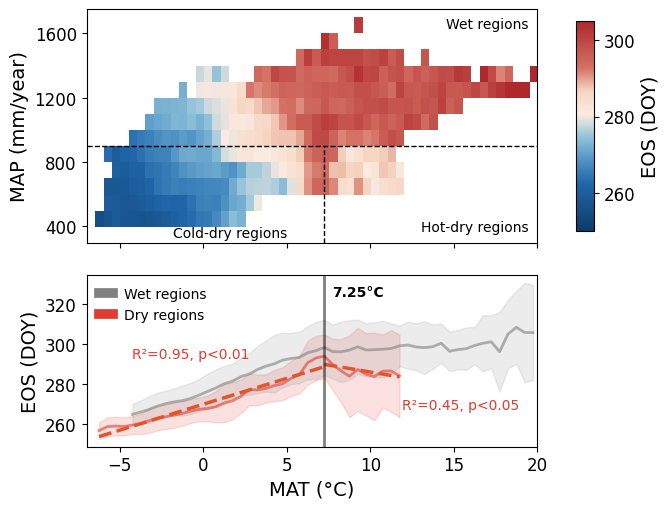

In [11]:
## Read and show EOS turning point
satellite = 'avhrr'

veg_type = 0
df = read_satellite_data(veg_type, satellite)
df = df[
    (df['annual_t'] >= -20) & (df['annual_t'] <= 20) &
    (df['annual_p'] >= 0) & (df['annual_p'] <= 4)
]

min_z_count = 50
min_eos, max_eos = 250, 305
figa = plot_grid(df, 'annual_t', 'annual_p', 'eos', 'AVHRR EOS', (min_eos, max_eos), min_z_count, satellite)
figa.savefig(f"../results/figure1/{satellite}/eos.png", dpi=300, bbox_inches='tight')

Read SPRUCE data

In [ ]:
## Read environment data
import pandas as pd
import glob
import os

# Define the base directory where your data is stored
base_dir = "../data/spruce_data/WEW_Complete_Environ_20240328"

# Find all CSV files matching the pattern
file_paths = glob.glob(os.path.join(base_dir, "*Complete_Environ_20240328.csv"))

# Initialize a list to store DataFrames
dfs = []
for file_path in file_paths:
    df = pd.read_csv(file_path, comment='#')
    # Keep only the relevant columns
    df = df[['TIMESTAMP', 'TA_2_0__1', 'Plot', 'Temp_target', 'CO2_trmt']]
    dfs.append(df)

# Combine all files into one DataFrame
data = pd.concat(dfs, ignore_index=True)

# ---------------------------
# First, try the original conversion (without infer_datetime_format)
data['timestamp'] = pd.to_datetime(data['TIMESTAMP'].str.strip(), errors='coerce')

# If there are any NaT values, use the fallback method for those rows
mask = data['timestamp'].isna()
if mask.any():
    # Keep the original timestamp string (if not already stripped)
    data.loc[mask, 'timestamp_str'] = data.loc[mask, 'TIMESTAMP'].str.strip()
    # Extract the expected datetime pattern from the string.
    # This pattern assumes the timestamp is in the format "YYYY-MM-DD HH:MM:SS"
    data.loc[mask, 'timestamp_extracted'] = data.loc[mask, 'timestamp_str'].str.extract(
        r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})', expand=False
    )
    # Convert the extracted string into a datetime object.
    data.loc[mask, 'timestamp'] = pd.to_datetime(data.loc[mask, 'timestamp_extracted'], errors='coerce')

# Extract the year from the unified timestamp column
data['year'] = data['timestamp'].dt.year

# Drop rows with missing temperature or timestamp
data_clean = data.dropna(subset=['timestamp', 'TA_2_0__1'])

# Group by year and Plot, compute annual average temperature
df_annual = data_clean.groupby(['year', 'Plot'])['TA_2_0__1'].mean().reset_index()
df_annual.rename(columns={'TA_2_0__1': 'annual_temp'}, inplace=True)
# print(df_annual)
# Pivot annual_temp
pivot_df = df_annual.pivot(index="Plot", columns="year", values="annual_temp")

# Rename columns to include variable name and year
pivot_df.columns = [f"annual_temp_{int(year)}" for year in pivot_df.columns]

# Reset index to bring 'Plot' back as a column and rename to lowercase 'plot'
df_envir = pivot_df.reset_index()
df_envir.rename(columns={'Plot': 'plot'}, inplace=True)

In [ ]:
## Read ORNL PhenoCam data 25% rising and falling
import pandas as pd
import numpy as np

## ORNL PhenoCam data
df = pd.read_csv("../data/spruce_data/ORNL_PhenoCam/Phenology_TransitionDates_3day_2015_2023.csv")

# Create SOS dataframe for 'rising' direction
sos_df = df[df['direction'] == 'rising'].pivot_table(
    index=['veg_type', 'plot'], 
    columns='year', 
    values='transition_doy'
)
# Rename columns to include the prefix "sos_"
sos_df.columns = ['sos_' + str(col) for col in sos_df.columns]
sos_df = sos_df.reset_index()

# Create EOS dataframe for 'falling' direction
eos_df = df[df['direction'] == 'falling'].pivot_table(
    index=['veg_type', 'plot'], 
    columns='year', 
    values='transition_doy'
)
# Rename columns to include the prefix "eos_"
eos_df.columns = ['eos_' + str(col) for col in eos_df.columns]
eos_df = eos_df.reset_index()

# Merge the two dataframes on veg_type and plot
result_df = pd.merge(sos_df, eos_df, on=['veg_type', 'plot'], how='outer')

## Only to generate table for model
df = result_df.merge(df_envir, on="plot", how="inner")

df_pheno = result_df

df_pheno = df_pheno.merge(df_envir, on="plot", how="inner")
elevated_plots = [4, 10, 11, 16, 19]
df_pheno['co2_level'] = np.where(df_pheno['plot'].isin(elevated_plots), 'elevated', 'ambient')
df_pheno = df_pheno[df_pheno["co2_level"] == "ambient"]

eos_cols = df_pheno.loc[:, df_pheno.columns.str.contains('eos')]

Plot Fig. 1b

115


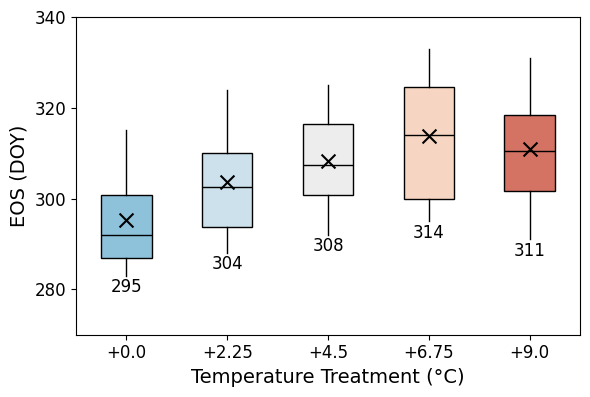

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Drop eos_2015 column if it exists
df_pheno = df_pheno.drop(columns=["eos_2015"], errors='ignore')

# Define temperature mapping from the image
temp_mapping = {
    2: "Ambient",
    4: "+4.5",
    5: "Ambient",
    6: "Control",
    7: "Ambient",
    8: "+6.75",
    9: "Ambient",
    10: "+9",
    11: "+2.25",
    13: "+4.5",
    14: "Ambient",
    15: "Ambient",
    16: "+6.75",
    17: "+9",
    19: "Control",
    20: "+2.25",
    21: "Ambient"
}

# Map plot to Temperature and numeric values
df_pheno["Temperature"] = df_pheno["plot"].map(temp_mapping)
temp_numeric_map = {
    "Control": 0,
    "+2.25": 2.25,
    "+4.5": 4.5,
    "+6.75": 6.75,
    "+9": 9
}
df_pheno["Temp_numeric"] = df_pheno["Temperature"].map(temp_numeric_map)

# Melt EOS columns into long format
eos_cols = [col for col in df_pheno.columns if col.startswith("eos_")]
df_long = df_pheno.melt(id_vars=["plot", "Temp_numeric"], value_vars=eos_cols,
                        var_name="Year", value_name="EOS")

# Drop missing EOS values
df_long = df_long.dropna()

# Group EOS by Temp_numeric to prepare data for boxplot
groups = df_long.groupby("Temp_numeric")["EOS"].apply(list).reset_index()

# Prepare boxplot data and positions
data = groups["EOS"].tolist()
positions = range(len(groups))  # integer positions for each box

## Count site-year
count = sum(len(inner_list) for inner_list in data)
print(count)

# Calculate mean EOS for each temperature group
means = groups["EOS"].apply(np.mean)

# Define gradient colors for the boxes
colors = ["#8ec1da", "#cde1ec", "#ededed", "#f6d6c2", "#d47264"]

# plt.figure(figsize=(6, 3))
plt.figure(figsize=(6, 4))

# Create the boxplot
bp = plt.boxplot(data, positions=positions, patch_artist=True,
                 medianprops=dict(color='black'),
                 capprops=dict(visible=False),
                 showfliers=False)

# Apply the gradient colors
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Plot mean values as black 'x' marks
plt.scatter(positions, means, color='black', marker='x', s=100, label='Mean', zorder=5)

# Annotate mean values just below the lower vertical whisker bar (vertical line)
for i, mean in enumerate(means):
    whisker = bp['whiskers'][2*i]  # lower whisker line for ith box
    xy = whisker.get_xydata()
    x = xy[0, 0]  # x coord of whisker line (vertical line so both points have same x)
    bottom_y = np.min(xy[:, 1])  # lowest y point of the whisker line

    plt.text(x, bottom_y - 0.5, f"{mean:.0f}", color='black',
             ha='center', va='top', fontsize=12)

# Set axis ticks and labels
# Format tick labels with "+" sign
tick_labels = [f"+{t}" for t in groups["Temp_numeric"]]
plt.xticks(positions, tick_labels, fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Temperature Treatment (°C)", fontsize=14)
plt.ylabel("EOS (DOY)", fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.ylim(270, 340)
plt.yticks([280, 300, 320, 340])

# Save figure
plt.savefig("../results/figure1/spruce/eos.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
## Show precipitation
import pandas as pd
import numpy as np

# Example data
data = {
    "annual_p_2016": [803.069],
    "annual_p_2017": [883.853],
    "annual_p_2018": [871.656],
    "annual_p_2019": [885.45],
    "annual_p_2020": [600.38],
    "annual_p_2021": [616.644],
    "annual_p_2022": [851.572],
    "annual_p_2023": [699.532]
}

df = pd.DataFrame(data)

# Calculate mean
mean_p = df.mean(axis=1)[0]

# Calculate standard deviation
std_p = df.std(axis=1)[0]

# Print mean ± std
print(f"Mean annual precipitation: {mean_p:.3f} ± {std_p:.3f}")

Mean annual precipitation: 776.519 ± 120.290


Read PhenoCam data

In [ ]:
import pandas as pd
df = pd.read_csv('../data/phenocam_data/tables/phenocam.csv')
df = df[df['veg_type'].isin(["EN", "DB", "DN"])]
df = df[df['latitude'] >= 30]

,site,veg_type,latitude,longitude,eos_2000,eos_2001,eos_2002,eos_2003,eos_2004,eos_2005,...,autumn_r_2015,autumn_r_2016,autumn_r_2017,autumn_r_2018,autumn_r_2019,autumn_r_2020,autumn_r_2021,autumn_r_2022,autumn_r_2023,autumn_r_2024
0,ICOSFR-Fon1,DB,48.476336,2.780100,NaN,NaN,NaN,NaN,NaN,NaN,...,8246308.0,8512866.0,8219974.0,9612751.0,7773211.5,8392392.0,8720076.0,8554663.0,9031638.0,7445250.0
1,NEON.D01.BART.DP1.00033,DB,44.063869,-71.287375,NaN,NaN,NaN,NaN,NaN,NaN,...,11591472.0,10154691.0,10902432.0,9090672.0,10292661.0,10684407.0,10073868.0,10569135.0,10194535.0,11133209.0
2,NEON.D01.BART.DP1.00033,EN,44.063869,-71.287375,NaN,NaN,NaN,NaN,NaN,NaN,...,11591472.0,10154691.0,10902432.0,9090672.0,10292661.0,10684407.0,10073868.0,10569135.0,10194535.0,11133209.0
4,NEON.D01.HARV.DP1.00033,DB,42.536911,-72.172650,NaN,NaN,NaN,NaN,NaN,NaN,...,11705682.0,10556488.0,10982800.0,8994208.0,10890213.0,10951392.0,10768034.0,11084176.0,10841483.0,11755628.0
5,NEON.D01.HARV.DP1.00033,EN,42.536911,-72.172650,NaN,NaN,NaN,NaN,NaN,NaN,...,11705682.0,10556488.0,10982800.0,8994208.0,10890213.0,10951392.0,10768034.0,11084176.0,10841483.0,11755628.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,willowcreek,DB,45.805986,-90.079120,NaN,NaN,NaN,NaN,NaN,NaN,...,9507561.0,9249205.0,9770160.0,8678092.0,8676255.0,10013376.0,10140887.0,10612011.0,9238492.0,11260354.0
795,windriver,EN,45.821283,-121.952083,NaN,NaN,NaN,NaN,NaN,NaN,...,10304377.0,8462248.0,9710922.0,10666112.0,9781129.0,10599292.0,9588461.0,11557622.0,10124545.0,10184737.0
796,witnesstree,DB,42.535562,-72.189570,NaN,NaN,NaN,NaN,NaN,NaN,...,11705682.0,10556488.0,10982800.0,8994208.0,10890213.0,10951392.0,10768034.0,11084176.0,10841483.0,11755628.0
798,woodshole,DB,41.549500,-70.643200,NaN,NaN,NaN,NaN,NaN,NaN,...,12218153.0,11401272.0,11128522.0,10167498.0,11467952.0,11576498.0,12128680.0,11689105.0,11682347.0,12580377.0


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

def plot_eos_vs_temp(df, threshold):
    # --- Identify relevant columns ---
    eos_cols = [c for c in df.columns if c.startswith("eos_")]
    annual_t_cols = [c for c in df.columns if c.startswith("annual_t_")]
    annual_p_cols = [c for c in df.columns if c.startswith("annual_p_")]

    eos_years = [int(c.split("_")[1]) for c in eos_cols]
    t_map = {int(c.split("_")[2]): c for c in annual_t_cols}
    p_map = {int(c.split("_")[2]): c for c in annual_p_cols}

    # --- Compute long-term means (only for valid EOS years) ---
    longterm_t, longterm_p, longterm_eos = [], [], []
    for _, row in df.iterrows():
        eos_values, t_values, p_values = [], [], []
        for year, eos_col in zip(eos_years, eos_cols):
            eos_val = row[eos_col]
            if pd.notna(eos_val):
                eos_values.append(eos_val)
                if year in t_map:
                    t_values.append(row[t_map[year]])
                if year in p_map:
                    p_values.append(row[p_map[year]])
        longterm_eos.append(np.nanmean(eos_values) if eos_values else np.nan)
        longterm_t.append(np.nanmean(t_values) if t_values else np.nan)
        longterm_p.append(np.nanmean(p_values) if p_values else np.nan)

    # --- Store and filter ---
    df = df.copy()
    df["longterm_eos"] = longterm_eos
    df["longterm_annual_t"] = np.array(longterm_t) - 273.5  # convert K → °C
    df["longterm_annual_p"] = longterm_p
    df = df[df["longterm_eos"] > 200]
    print(f"{df.shape[0]} sites used")

    # --- Define groups ---
    red_mask = df["longterm_annual_p"] < threshold
    gray_mask = ~red_mask
    dry_color = "#e03c31"  # red tone replacement

    # --- Regression helper ---
    def quadratic_regression(x, y):
        X = pd.DataFrame({"x": x, "x2": x**2})
        X = sm.add_constant(X)
        return sm.OLS(y, X, missing='drop').fit()

    # --- Fit quadratic for dry sites only ---
    red_model = quadratic_regression(df.loc[red_mask, "longterm_annual_t"],
                                     df.loc[red_mask, "longterm_eos"])

    # --- Formatting p-values ---
    def format_p(p):
        if p < 0.01:
            return "< 0.01"
        elif p < 0.05:
            return "< 0.05"
        else:
            return f"= {p:.2f}"


    # --- Figure setup ---
    fig = plt.figure(figsize=(6, 4))

    # Scatter points
    plt.scatter(df.loc[gray_mask, "longterm_annual_t"],
                df.loc[gray_mask, "longterm_eos"],
                color="gray", s=35, alpha=0.7, edgecolor='none',
                label="Wet sites")
    plt.scatter(df.loc[red_mask, "longterm_annual_t"],
                df.loc[red_mask, "longterm_eos"],
                color=dry_color, s=70, alpha=0.7, edgecolor='none',
                label="Dry sites")

    # --- Quadratic fit + 95% confidence & prediction intervals ---
    x_group = df.loc[red_mask, "longterm_annual_t"].dropna()
    if len(x_group) > 1:
        x_vals = np.linspace(x_group.min(), x_group.max(), 200)
        X_pred = pd.DataFrame({"x": x_vals, "x2": x_vals**2})
        X_pred = sm.add_constant(X_pred)

        # Generate predictions
        pred = red_model.get_prediction(X_pred)
        pred_summary = pred.summary_frame(alpha=0.05)  # 95% CI

        y_pred = pred_summary["mean"]
        ci_lower = pred_summary["mean_ci_lower"]
        ci_upper = pred_summary["mean_ci_upper"]
        pi_lower = pred_summary["obs_ci_lower"]
        pi_upper = pred_summary["obs_ci_upper"]

        # Plot regression line
        plt.plot(x_vals, y_pred, color=dry_color, linewidth=2, label="Quadratic fit (dry)")

        # Plot 95% confidence interval (mean prediction)
        plt.fill_between(x_vals, ci_lower, ci_upper, color=dry_color, alpha=0.15, label="95% CI (mean)")

        # # Plot 95% prediction interval (individual predictions)
        # plt.fill_between(x_vals, pi_lower, pi_upper, color=dry_color, alpha=0.1, label="95% PI (individual)")

    # --- Regression stats text ---
    plt.text(0.03, 0.97,
             f"R² = {red_model.rsquared:.2f}\n"
             f"p(t²) {format_p(red_model.pvalues['x2'])}\n"
             f"p(t)  {format_p(red_model.pvalues['x'])}",
             color=dry_color, transform=plt.gca().transAxes,
             fontsize=12, va='top')

    # --- Axis & style ---
    plt.xlabel("MAT (°C)", fontsize=14)
    plt.ylabel("EOS (DOY)", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # handles, labels = plt.gca().get_legend_handles_labels()
    # order = [labels.index("Dry sites"), labels.index("Wet sites")]
    
    # leg = plt.legend(
    #     [handles[i] for i in order],
    #     [labels[i] for i in order],
    #     fontsize=10,
    #     loc='upper right',
    #     bbox_to_anchor=(1.00, 1),   # slightly outside the plot
    #     frameon=True                # enable frame (box)
    # )
    
    # # Make the box opaque
    # frame = leg.get_frame()
    # frame.set_facecolor("white")    # solid white background
    # frame.set_alpha(1.0)            # fully opaque (no transparency)
    # frame.set_edgecolor("white")    # black border (optional)
    # frame.set_linewidth(0.8)

    plt.tight_layout()
    return fig, df


Plot Fig. 1c

280 sites used


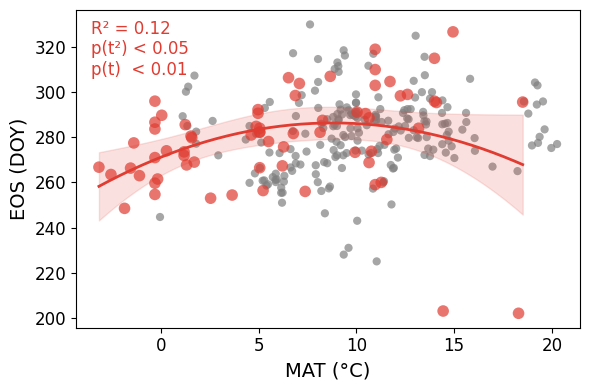

In [16]:
threshold  = 0.8
fig, long_term_mean_phenocam = plot_eos_vs_temp(df, threshold)
fig.savefig("../results/figure1/phenocam/eos.png", dpi=300, bbox_inches='tight')

In [417]:
## Check earliest year of valid data and site-year
long_term_mean_phenocam
df = long_term_mean_phenocam.dropna(axis=1, how='all')
df.drop(columns='longterm_eos', inplace=True)
counts = df.filter(like='eos').count()
total_eos = counts.sum()
print(total_eos)

1881


Read FLUXNET data

In [ ]:
import pandas as pd
df = pd.read_csv('../data/flux_data/tables/flux_50.csv')
df = df[df['latitude'] >= 30]

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

def plot_eos_vs_temp(df, threshold):
    # --- Identify relevant columns ---
    eos_cols = [c for c in df.columns if c.startswith("eos_")]
    annual_t_cols = [c for c in df.columns if c.startswith("annual_t_")]
    annual_p_cols = [c for c in df.columns if c.startswith("annual_p_")]

    eos_years = [int(c.split("_")[1]) for c in eos_cols]
    t_map = {int(c.split("_")[2]): c for c in annual_t_cols}
    p_map = {int(c.split("_")[2]): c for c in annual_p_cols}

    # --- Compute long-term means (only for valid EOS years) ---
    longterm_t, longterm_p, longterm_eos = [], [], []
    for _, row in df.iterrows():
        eos_values, t_values, p_values = [], [], []
        for year, eos_col in zip(eos_years, eos_cols):
            eos_val = row[eos_col]
            if pd.notna(eos_val):
                eos_values.append(eos_val)
                if year in t_map:
                    t_values.append(row[t_map[year]])
                if year in p_map:
                    p_values.append(row[p_map[year]])
        longterm_eos.append(np.nanmean(eos_values) if eos_values else np.nan)
        longterm_t.append(np.nanmean(t_values) if t_values else np.nan)
        longterm_p.append(np.nanmean(p_values) if p_values else np.nan)

    # --- Store and filter ---
    df = df.copy()
    df["longterm_eos"] = longterm_eos
    df["longterm_annual_t"] = np.array(longterm_t) - 273.5  # convert K → °C
    df["longterm_annual_p"] = longterm_p
    df = df[df["longterm_eos"] > 200]
    print(df.shape)
    # --- Define groups ---
    red_mask = df["longterm_annual_p"] < threshold
    gray_mask = ~red_mask
    dry_color = "#e03c31"  # red tone replacement

    # --- Regression helper ---
    def quadratic_regression(x, y):
        X = pd.DataFrame({"x": x, "x2": x**2})
        X = sm.add_constant(X)
        return sm.OLS(y, X, missing='drop').fit()

    # --- Fit quadratic for dry sites only ---
    red_model = quadratic_regression(df.loc[red_mask, "longterm_annual_t"],
                                     df.loc[red_mask, "longterm_eos"])

    # --- Formatting p-values ---
    def format_p(p):
        if p < 0.01:
            return "< 0.01"
        elif p < 0.05:
            return "< 0.05"
        else:
            return f"= {p:.2f}"


    # --- Figure setup ---
    fig = plt.figure(figsize=(6, 4))

    # Scatter points (same size for all)
    plt.scatter(df.loc[gray_mask, "longterm_annual_t"],
                df.loc[gray_mask, "longterm_eos"],
                color="gray", s=35, alpha=0.7, edgecolor='none',
                label="Wet sites")
    plt.scatter(df.loc[red_mask, "longterm_annual_t"],
                df.loc[red_mask, "longterm_eos"],
                color=dry_color, s=70, alpha=0.7, edgecolor='none',
                label="Dry sites")

    # --- Quadratic fit for dry (red) sites + 95% confidence band ---
    x_group = df.loc[red_mask, "longterm_annual_t"].dropna()
    if len(x_group) > 1:
        x_vals = np.linspace(x_group.min(), x_group.max(), 200)
        X_pred = pd.DataFrame({"x": x_vals, "x2": x_vals**2})
        X_pred = sm.add_constant(X_pred)

        # Get predicted mean and confidence intervals
        pred = red_model.get_prediction(X_pred)
        pred_summary = pred.summary_frame(alpha=0.05)  # 95% CI for mean prediction

        y_pred = pred_summary["mean"]
        ci_lower = pred_summary["mean_ci_lower"]
        ci_upper = pred_summary["mean_ci_upper"]

        # Plot regression line
        plt.plot(x_vals, y_pred, color=dry_color, linewidth=2, label="Quadratic fit (dry)")

        # Plot confidence interval band
        plt.fill_between(x_vals, ci_lower, ci_upper, color=dry_color, alpha=0.15, label="95% CI")

    # --- Regression stats text ---
    plt.text(0.03, 0.97,
             f"R² = {red_model.rsquared:.2f}\n"
             f"p(t²) {format_p(red_model.pvalues['x2'])}\n"
             f"p(t)  {format_p(red_model.pvalues['x'])}",
             color=dry_color, transform=plt.gca().transAxes,
             fontsize=12, va='top')

    # --- Axis & style ---
    plt.xlabel("MAT (°C)", fontsize=14)
    plt.ylabel("EOS (DOY)", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlim(-9, 16)
    plt.ylim(200, 300)

    plt.tight_layout()
    return fig, df


Plot Fig. 1d

(77, 547)


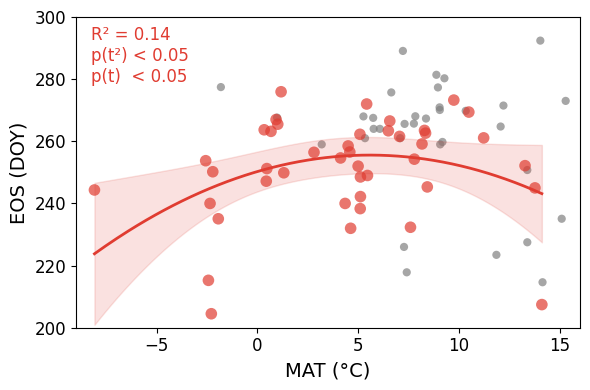

In [22]:
threshold  = 0.9
fig, long_term_mean_flux = plot_eos_vs_temp(df, threshold)
fig.savefig("../results/figure1/flux/eos.png", dpi=300, bbox_inches='tight')

In [343]:
## Check earliest year of valid data and site-year
long_term_mean_flux
df = long_term_mean_flux.dropna(axis=1, how='all')
df.drop(columns='longterm_eos', inplace=True)
counts = df.filter(like='eos').count()
total_eos = counts.sum()
print(total_eos)

695
